## Importing Libraries

In [581]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot as plt
import seaborn as sns


## Loading the Data

In [582]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [583]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

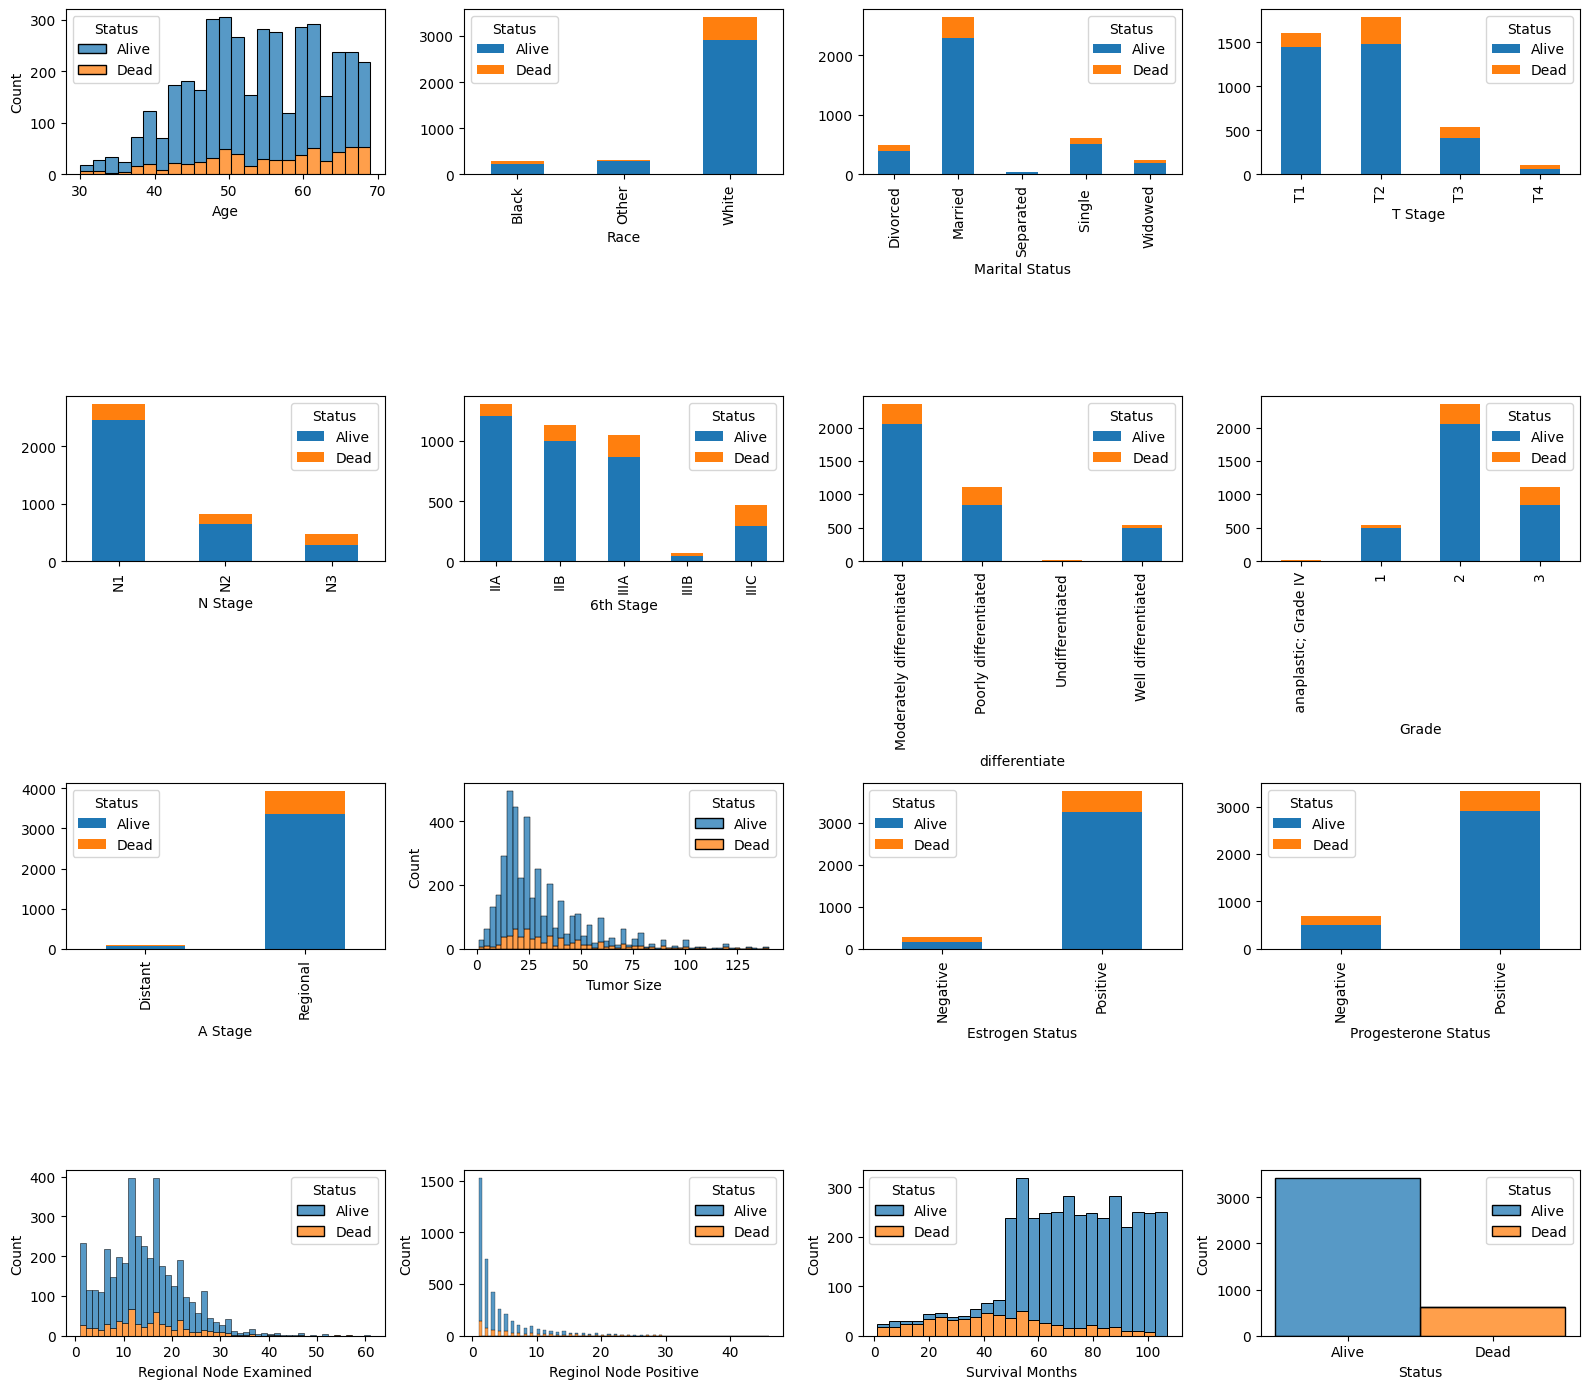

In [584]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        ct = pd.crosstab(index=df[c], columns=df['Status'])
        a = ct.plot(kind='bar', stacked=True,ax=ax)
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax, multiple='stack')
plt.tight_layout()

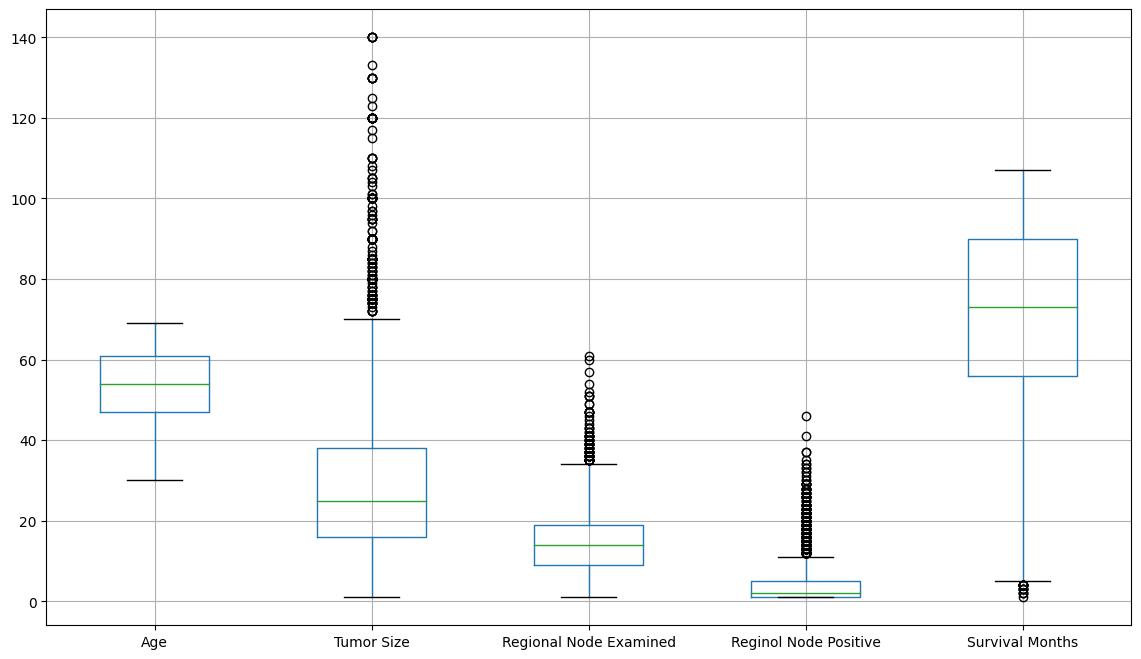

In [585]:
df.loc[:,numerical_cols].boxplot(figsize=(14,8));

## Outlier Detection

<Axes: ylabel='Frequency'>

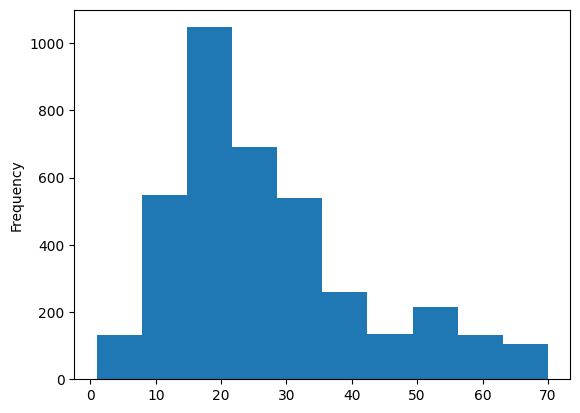

In [586]:
# Calculate the IQR range
Q1 = df['Tumor Size'].quantile(0.25)
Q3 = df['Tumor Size'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Tumor Size'
outliers_tumor_size = df[(df['Tumor Size'] < lower_bound) | (df['Tumor Size'] > upper_bound)]

# Remove outliers from 'Tumor Size'
df = df[(df['Tumor Size'] >= lower_bound) & (df['Tumor Size'] <= upper_bound)]

df['Tumor Size'].plot.hist()

<Axes: ylabel='Frequency'>

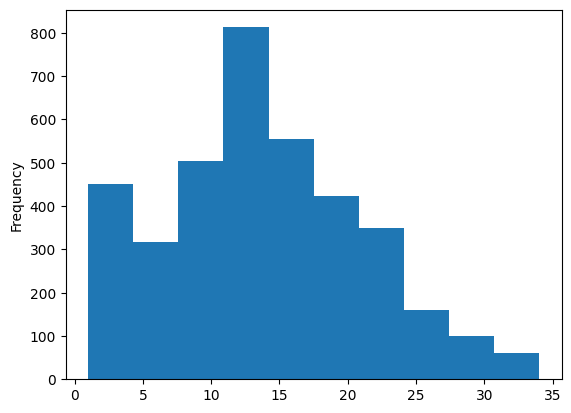

In [587]:
# Calculate the IQR range
Q1 = df['Regional Node Examined'].quantile(0.25)
Q3 = df['Regional Node Examined'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers for 'Regional Node Examined'
outliers_regional_node = df[(df['Regional Node Examined'] < lower_bound) | (df['Regional Node Examined'] > upper_bound)]

# Remove outliers from 'Regional Node Examined'
df = df[(df['Regional Node Examined'] >= lower_bound) & (df['Regional Node Examined'] <= upper_bound)]

df['Regional Node Examined'].plot.hist()

## Train Test Split

In [588]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


## Preprocessing

In [589]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

## Data Balancing

In [590]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2044, 1: 347})


In [591]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 1749, 0: 1384})


## Support Functions

In [592]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

In [593]:
def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    f1 =f1_score(y_real,y_pred, pos_label=1)
    precision = precision_score(y_real, y_pred, pos_label=1)
    recall =recall_score(y_real,y_pred, pos_label=1)
    jaccard = jaccard_score(y_real, y_pred, pos_label=1)
    return [accuracy, f1, precision, recall, jaccard]

## LDA

In [594]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.842809,0.552381,0.471545,0.666667,0.381579


In [595]:
# Exploring LDA
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,labels
0,-1.846315,0
1,-1.601424,0
2,-1.792185,0
3,-1.874241,0
4,-1.441935,0
...,...,...
3128,0.259917,1
3129,0.783831,1
3130,1.138180,1
3131,2.249401,1


<Axes: xlabel='0'>

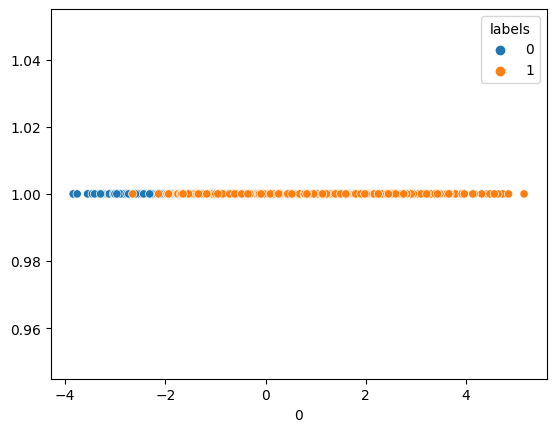

In [596]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

## KNN

In [597]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='Recall', ascending=False)
print(sorted_results_knn)

          Accuracy        F1 Precision    Recall   Jaccard
model k                                                   
KNN   49  0.647157   0.35474  0.241667  0.666667  0.215613
      47  0.658863    0.3625  0.248927  0.666667  0.221374
      45  0.658863    0.3625  0.248927  0.666667  0.221374
      43  0.662207   0.36478  0.251082  0.666667  0.223077
      41  0.657191  0.361371  0.247863  0.666667  0.220532
      17  0.665552  0.367089  0.253275  0.666667  0.224806
      19   0.67893  0.376623  0.262443  0.666667     0.232
      31  0.655518  0.360248  0.246809  0.666667  0.219697
      29  0.643813  0.348624    0.2375  0.655172  0.211111
      15  0.667224  0.364217  0.252212  0.655172  0.222656
      37  0.653846   0.35514   0.24359  0.655172  0.215909
      39  0.653846  0.351097  0.241379  0.643678  0.212928
      35  0.650502   0.34891  0.239316  0.643678  0.211321
      33  0.645485  0.345679  0.236287  0.643678  0.208955
      25  0.673913  0.364821  0.254545  0.643678  0.2231

In [598]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df

k value of the first row: 49


,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.842809,0.552381,0.471545,0.666667,0.381579
KNN-49,0.647157,0.35474,0.241667,0.666667,0.215613


## Logistic Regression

In [599]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='Recall', ascending=False)
print(sorted_results_logreg)

                 Accuracy        F1 Precision    Recall   Jaccard
model  C                                                         
LogReg 0.1       0.779264  0.507463  0.375691  0.781609      0.34
       1.0       0.831104  0.555066      0.45  0.724138  0.384146
       100000.0  0.841137   0.56621  0.469697  0.712644  0.394904
       10000.0   0.841137   0.56621  0.469697  0.712644  0.394904
       1000.0    0.841137   0.56621  0.469697  0.712644  0.394904
       100.0     0.841137   0.56621  0.469697  0.712644  0.394904
       10.0      0.839465  0.563636  0.466165  0.712644  0.392405


In [600]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='Recall', ascending=False)

c value of the first row: 0.1


,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.779264,0.507463,0.375691,0.781609,0.34
LDA,0.842809,0.552381,0.471545,0.666667,0.381579
KNN-49,0.647157,0.35474,0.241667,0.666667,0.215613


## Random Forest

In [601]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]   # Minimum number of samples required to split an internal node
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='recall',
                           cv=5,
                           refit='recall')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Print the best score found by GridSearchCV
print("Best Score:", grid_search.best_score_)

# Get the best model found by GridSearchCV
best_rfmodel = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.9817093737208349


In [602]:
y_pred_rf = best_rfmodel.predict(X_val)
results_df.loc['Random Forest', :] = compute_metrics(y_val, y_pred_rf)

results_df.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Precision,Recall,Jaccard
LogReg-0.1,0.779264,0.507463,0.375691,0.781609,0.34
LDA,0.842809,0.552381,0.471545,0.666667,0.381579
KNN-49,0.647157,0.35474,0.241667,0.666667,0.215613
Random Forest,0.82107,0.515837,0.425373,0.655172,0.347561


## Feature Importance

<Axes: >

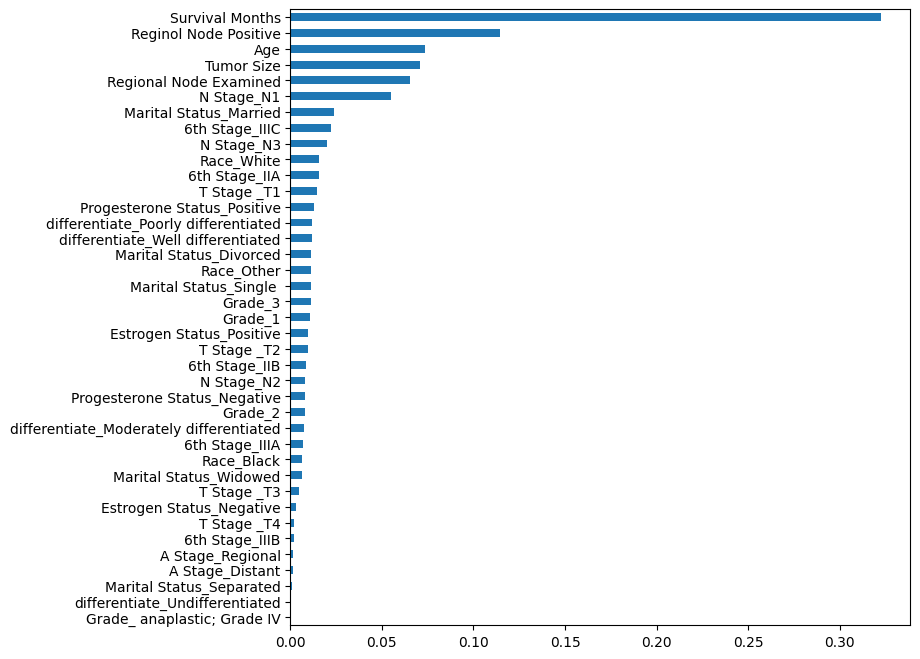

In [603]:
var_imp = pd.DataFrame({'importance': best_rfmodel.feature_importances_},
                       index=X_train.columns)

var_imp.sort_values(by='importance').plot.barh(figsize=(8,8),
                                               legend=False)

## Generalization Performance

In [604]:
logreg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
logreg = logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [605]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.7727272727272727
recall_score:  0.7981651376146789
jaccard_score:  0.33852140077821014
f1_score:  0.5058139534883721
precision_score:  0.3702127659574468
